In [1]:
import sys
sys.path.insert(0, '../../wildlife-tools')
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as T
import timm

from wildlife_datasets import datasets
from wildlife_tools.data import WildlifeDataset
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier

import os
sys.path.append('..')
import pandas as pd
from wildlife_datasets import datasets, loader, analysis
from wildlife_datasets.analysis import display_statistics, plot_bbox_segmentation, plot_grid
from wildlife_datasets.splits import visualize_split
from wildlife_datasets.splits import TimeCutoffSplit, TimeProportionSplit


In [2]:
# #Loading the dataset

# datasets = loader.load_datasets(
#     [
#     datasets.AAUZebraFish,
#     datasets.AerialCattle2017,
#     datasets.ATRW,
#     datasets.BelugaID,
#     datasets.BirdIndividualID,
#     datasets.BirdIndividualIDSegmented,
#     datasets.CatIndividualImages,
#     datasets.CTai,
#     datasets.CZoo,
#     datasets.CowDataset,
#     datasets.Cows2021v2,
#     datasets.DogFaceNet,
#     datasets.Drosophila,
#     datasets.FriesianCattle2015v2,
#     datasets.FriesianCattle2017,
#     datasets.GiraffeZebraID,
#     datasets.Giraffes,
#     datasets.GreenSeaTurtles,
#     datasets.HappyWhale,
#     datasets.HumpbackWhaleID,
#     datasets.HyenaID2022,
#     datasets.IPanda50,
#     datasets.LeopardID2022,
#     datasets.LionData,
#     datasets.MacaqueFaces,
#     datasets.MPDD,
#     datasets.NDD20v2,
#     datasets.NOAARightWhale,
#     datasets.NyalaData,
#     datasets.OpenCows2020,
#     datasets.PolarBearVidID,
#     datasets.SealID,
#     datasets.SealIDSegmented,
#     datasets.SeaStarReID2023,
#     datasets.SeaTurtleID2022,
#     datasets.SeaTurtleIDHeads,
#     datasets.SMALST,
#     datasets.StripeSpotter,
#     datasets.WhaleSharkID,
#     datasets.ZindiTurtleRecall
# ]
# ,
#     'data',
#     'dataframes'
# )

In [3]:
#Loading the dataset

names = [datasets.AAUZebraFish,
    datasets.CatIndividualImages,
    datasets.CTai,
    datasets.CZoo,
    datasets.CowDataset,
    datasets.DogFaceNet,
    datasets.Drosophila,
    datasets.LionData,
    datasets.MacaqueFaces,
    datasets.MPDD,
    datasets.NDD20v2,
    datasets.NyalaData,
    datasets.PolarBearVidID,
    datasets.SealIDSegmented,
    datasets.SeaStarReID2023,
    datasets.SeaTurtleID2022,
    datasets.SeaTurtleIDHeads,
    datasets.StripeSpotter,
    datasets.ZindiTurtleRecall
]

In [4]:
l = ['datasets.AAUZebraFish',
 'datasets.CatIndividualImages',
 'datasets.CTai',
 'datasets.CZoo',
 'datasets.CowDataset',
 'datasets.DogFaceNet',
 'datasets.Drosophila'
 'datasets.LionData',
 'datasets.MacaqueFaces',
 'datasets.MPDD',
 'datasets.NDD20v2',
 'datasets.NyalaData',
 'datasets.PolarBearVidID',
 'datasets.SealIDSegmented',
 'datasets.SeaStarReID2023',
 'datasets.SeaTurtleID2022',
 'datasets.SeaTurtleIDHeads',
 'datasets.StripeSpotter',
 'datasets.ZindiTurtleRecall']

In [5]:
roots = ['data/' + str(dataset).split('.')[1] for dataset in l]
roots

['data/AAUZebraFish',
 'data/CatIndividualImages',
 'data/CTai',
 'data/CZoo',
 'data/CowDataset',
 'data/DogFaceNet',
 'data/Drosophiladatasets',
 'data/MacaqueFaces',
 'data/MPDD',
 'data/NDD20v2',
 'data/NyalaData',
 'data/PolarBearVidID',
 'data/SealIDSegmented',
 'data/SeaStarReID2023',
 'data/SeaTurtleID2022',
 'data/SeaTurtleIDHeads',
 'data/StripeSpotter',
 'data/ZindiTurtleRecall']

Analysis and Visual Reidentification using MegaDescriptor

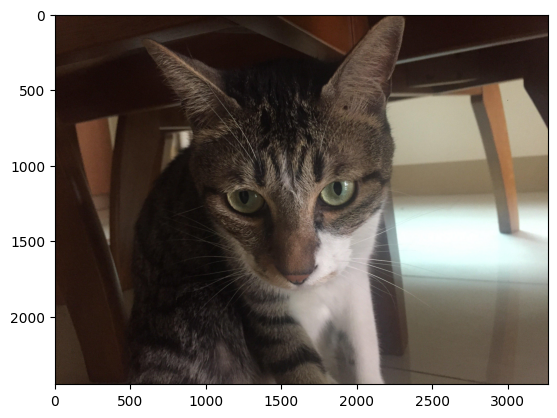

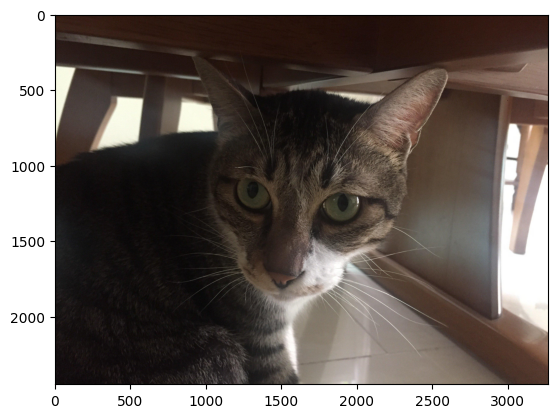

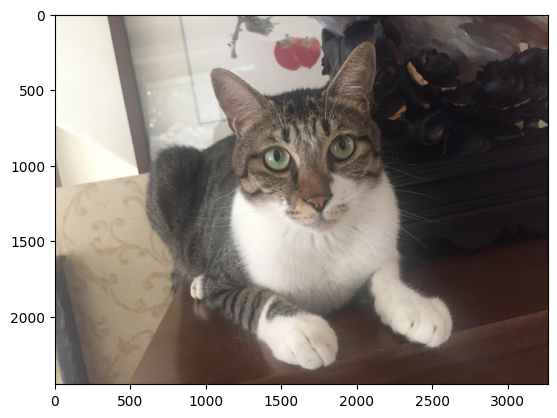

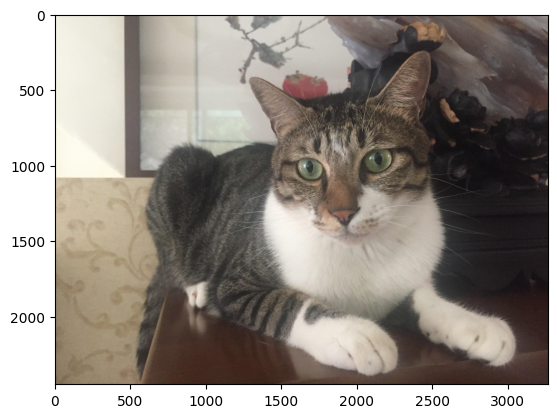

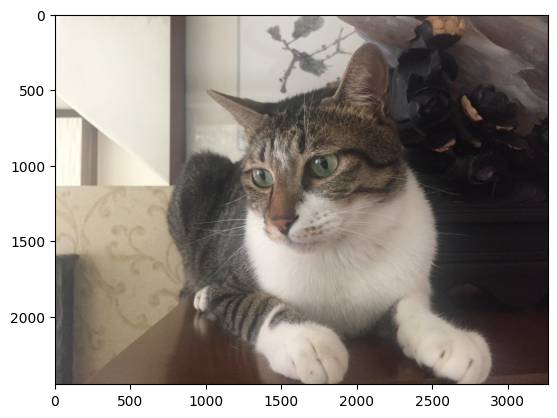

In [6]:
root = roots[1]
m = names[1](root)
df = m.df
plot_bbox_segmentation(df, root, 5)

In [7]:
transform = T.Compose([T.Resize([224, 224]), T.ToTensor(), T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
dataset_database = WildlifeDataset(df.iloc[100:,:], root, transform=transform)
dataset_query = WildlifeDataset(df.iloc[:100,:], root, transform=transform)

In [8]:
from wildlife_tools.features import DeepFeatures

name = 'hf-hub:BVRA/MegaDescriptor-T-224'
extractor = DeepFeatures(timm.create_model(name, num_classes=0, pretrained=True))

In [9]:
# Assuming df contains your entire dataset
dataset = WildlifeDataset(df, root, transform=transform)

# Extracting the query instances and database instances
dataset_query = WildlifeDataset(df.iloc[:100, :], root, transform=transform)
dataset_database = WildlifeDataset(df.iloc[100:, :], root, transform=transform)

query_features, database_features = extractor(dataset_query), extractor(dataset_database)

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████| 101/101 [43:16<00:00, 25.71s/it]


In [10]:
print(f'Query features shape: {query_features.shape}, Database features shape: {database_features.shape}')

Query features shape: (100, 768), Database features shape: (12921, 768)


In [11]:
import numpy as np

In [12]:
from wildlife_tools.similarity import CosineSimilarity

# Cosine similarity between deep features
similarity = CosineSimilarity()
sim = similarity(query_features, database_features)['cosine']
print("Similarity matrix: \n", sim.shape)

Similarity matrix: 
 (100, 12921)


In [13]:
# classifier = KnnClassifier(k=1, database_labels=dataset_database.labels_string)
# predictions = classifier(similarity['cosine'])

# Nearest neigbour classifier using the similarity
classifier = KnnClassifier(k=1, database_labels=dataset_database.labels_string)
preds = classifier(sim)
print(type(preds))
print("Prediction \t", preds)
print("Ground truth \t", dataset_query.labels_string)



<class 'numpy.ndarray'>
Prediction 	 ['272' '317' '272' '272' '410' '376' '376' '376' '412' '446' '376' '380'
 '446' '462' '431' '376' '376' '399' '348' '348' '348' '348' '10' '399'
 '10' '422' '13' '342' '342' '13' '10' '342' '180' '13' '13' '234' '8'
 '106' '317' '402' '317' '439' '10' '317' '317' '328' '402' '10' '402'
 '317' '402' '10' '4' '4' '4' '4' '4' '4' '294' '4' '4' '284' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '436' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '272' '127' '295' '446' '448' '4' '450' '400' '148' '148' '4' '4'
 '147' '4' '4']
Ground truth 	 ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4']


D:\Classroom\Project\p1\wildlife-tools\wildlife_tools\inference\classifier.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T


In [14]:
# Importing metrics
from wildlife_datasets.metrics import accuracy, balanced_accuracy, precision, recall, f1

# Assuming y_true and y_pred are your true labels and predictions respectively
y_true = dataset_query.labels_string  # True labels
y_pred = preds  # Predicted labels

# Computing evaluation metrics
acc = accuracy(y_true, y_pred)
bal_acc = balanced_accuracy(y_true, y_pred)
prec = precision(y_true, y_pred)
rec = recall(y_true, y_pred)
f1_score = f1(y_true, y_pred)

# Printing the computed metrics
print("Accuracy:", acc)
print("Balanced Accuracy:", bal_acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1_score)

Accuracy: 0.35
Balanced Accuracy: 0.18229166666666666
Precision: 0.027777777777777776
Recall: 0.02025462962962963
F1 Score: 0.023427041499330656


c:\Users\HP\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
